In [138]:
### Define Chain(s)

from niagara import Chain, Model, ModelIntrinsicLogProb, NullTransformation, LogisticRegressionCalibrator
from niagara import OpenAIClient, FireworksClient

llama_chain = Chain(
    models = [
        Model(
            model_name=name, 
            thresholds={"reject": -10000, "accept": 0.0},
            conf_signal=ModelIntrinsicLogProb(),
            conf_signal_transform=NullTransformation(),
            conf_signal_calibrator=LogisticRegressionCalibrator()
        )
        for name in ["llama3.2-1b", "llama3.2-3b", "llama3.1-8b", "llama3.1-70b", "llama3.1-405b"]
    ]
)

qwen_oai_chain = Chain(
    models = [
        Model(
            model_name=name, 
            thresholds={"reject": -10000, "accept": 0.0},
            conf_signal=ModelIntrinsicLogProb(),
            conf_signal_transform=NullTransformation(),
            conf_signal_calibrator=LogisticRegressionCalibrator(),
            client=client
        )
        for name, client in [("gpt-4o-mini", OpenAIClient()), ("qwen2.5-32b-coder-instruct", FireworksClient()), ("qwen2.5-72b-instruct", FireworksClient()), ("gpt-4o", OpenAIClient())]
    ]
)

In [139]:
### Select chain, benchmark, transformation, and grab data

import pickle
from niagara import OneSidedAsymptoticLog, TwoSidedAsymptoticLog

PRETTY_NAMES = {
    "xsum": "XSum",
    "mmlu": "MMLU",
    "medmcqa": "MedMCQA",
    "triviaqa": "TriviaQA",
    "truthfulqa": "TruthfulQA",
    "gsm8k": "GSM8K"
}

NAME = "xsum"
TRANSFORM = TwoSidedAsymptoticLog()
CHAIN_NAME = "llama_chain"
CHAIN = llama_chain

# Update the transformation for the chain
for model in CHAIN.models:
    model.conf_signal_transform = TRANSFORM

with open(f'../benchmarks/data/{NAME}/chain_results/{NAME}_full_{CHAIN_NAME}_results_train.pkl', 'rb') as f:
    results_train = pickle.load(f)
with open(f'../benchmarks/data/{NAME}/chain_results/{NAME}_full_{CHAIN_NAME}_results_test.pkl', 'rb') as f:
    results_test = pickle.load(f)

In [140]:
### Compute calibrated confidence values

process_scores = lambda scores: sum(scores.values()) >= 20

if NAME=="xsum":
    raw_corr_train = { k: [process_scores(x) for x in v] for k,v in results_train['model_correctness'].items() }
else:
    raw_corr_train= results_train['model_correctness']

raw_conf_train = results_train['raw_confidences']

corr_train = [
    raw_corr_train[model_name] for model_name in CHAIN.model_names
]

transformed_conf_train = [ 
    list(TRANSFORM.transform_confidence_signal(raw_conf_train[model_name]))
        for model_name in CHAIN.model_names
]

calibration_data = [
    {"correctness": corr, "transformed_confidence": conf} 
        for (corr, conf, model_name) 
            in zip(corr_train, transformed_conf_train, CHAIN.model_names)
]

CHAIN.calibrate(calibration_data)

calibrated_conf_train = [
    list(
        CHAIN.models[model_idx].conf_signal_calibrator.calibrate_confidence_signal(
            transformed_conf_train[model_idx]
        )
    )
    for model_idx in range(len(CHAIN.model_names))
]

Optimization terminated successfully.
         Current function value: 0.251511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.478912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447967
         Iterations 6


In [141]:
### Compute test data

if NAME=="xsum":
    raw_corr_test = { k: [process_scores(x) for x in v] for k,v in results_test['model_correctness'].items() }
else:
    raw_corr_test= results_test['model_correctness']

raw_conf_test = results_test['raw_confidences']

corr_test = [
    raw_corr_test[model_name] for model_name in CHAIN.model_names
]

transformed_conf_test = [ 
    list(TRANSFORM.transform_confidence_signal(raw_conf_test[model_name]))
        for model_name in CHAIN.model_names
]

calibrated_conf_test = [
    list(
        CHAIN.models[model_idx].conf_signal_calibrator.calibrate_confidence_signal(
            transformed_conf_test[model_idx]
        )
    )
    for model_idx in range(len(CHAIN.model_names))
]

In [391]:
from tqdm import tqdm
import numpy as np
from statsmodels.distributions.copula.api import GumbelCopula, IndependenceCopula
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau

def compute_cramer_von_mises(C, n_grid=1000):
    """ Compute Cramer von Mises statistic. """

    # Step 1: Compute cdf K_empirical using empirical copula
    n = C.shape[0] # this is the number of rows
    U_ij = (np.argsort(np.argsort(C, axis=0), axis=0) + 1)/(n+1)
    V_i_empirical = np.array([ np.mean(np.all(U_ij <= U_ij[[i],:], axis=1)) for i in range(n) ])
    K_empirical = ECDF(V_i_empirical)

    # Step 2: Compute cdf K_fitted using Gumbel copula
    kendall_tau = kendalltau(C[:,0], C[:,1]).statistic
    gumbel_theta = 1/(1-kendall_tau)
    V_i_fitted = np.exp(-np.sum((-np.log(U_ij)) ** (gumbel_theta), axis=1)**(1/gumbel_theta))
    K_fitted = ECDF(V_i_fitted)

    # Step 3: Compute Cramer-von Mises statistic, via trapezoidal rule
    integration_grid = np.linspace(0, 1, n_grid)
    integrand = [ np.sqrt(n) * (K_empirical(v) - K_fitted(v))**2 for v in integration_grid ]
    sum_1 = np.sum(integrand[1:] * np.diff(K_fitted(integration_grid)))
    sum_2 = np.sum(integrand[:-1] * np.diff(K_fitted(integration_grid)))
    integral = (sum_1 + sum_2) / 2

    return integral


def run_parametric_bootstrap(C, B=1000):
    """ Carry out parametric bootstrap. """
    cvm_stats = []
    theta_list = []
    integration_grid = np.linspace(0, 1, 1000)

    for b in tqdm(range(B)):
        n = C.shape[0]
        null_kendall_tau = kendalltau(C[:,0], C[:,1]).statistic
        null_theta = 1/(1-null_kendall_tau)

        try:
            null_copula = GumbelCopula(null_theta, k_dim=2)
            null_samples = null_copula.rvs(nobs=n)
        except ValueError as e: # check if theta is <= 1
            assert null_theta <= 1
            # sample from independence copula instead
            null_copula = IndependenceCopula(k_dim=2)
            null_samples = null_copula.rvs(nobs=n)

        # Compute K dist by fitting Gumbel copula
        theta_b = 1/(1-kendalltau(null_samples[:,0], null_samples[:,1]).statistic)
        theta_list.append(theta_b)
        V_i_fitted_b = np.exp(
            -np.sum((-np.log(null_samples)) ** (theta_b), axis=1)**(1/theta_b)
        )
        K_fitted_b = ECDF(V_i_fitted_b)

        # Compute K dist with empirical copula
        U_ij_b = (np.argsort(np.argsort(null_samples, axis=0), axis=0) + 1)/(n+1)
        V_i_empirical_b = np.array([ np.mean(np.all(U_ij_b <= U_ij_b[[i],:], axis=1)) for i in range(n) ])
        K_empirical_b = ECDF(V_i_empirical_b)

        # Compute Cramer-von Mises statistic
        integrand_b = [ np.sqrt(n) * (K_empirical_b(v) - K_fitted_b(v))**2 for v in integration_grid ]
        sum_1_b = np.sum(integrand_b[1:] * np.diff(K_fitted_b(integration_grid)))
        sum_2_b = np.sum(integrand_b[:-1] * np.diff(K_fitted_b(integration_grid)))
        integral_b = (sum_1_b + sum_2_b) / 2
        cvm_stats.append(integral_b)

    # Get results
    return cvm_stats, theta_list


def compute_pval(test_statistic, bootstrapped_values):
    """ Compute p value for Cramer von Mises with parametrized bootstrapping. """
    pval = np.mean(np.array(bootstrapped_values) >= test_statistic)
    return pval


def compute_pval_e2e(C, B=1000, return_test_statistic=False):
    """ Compute end-to-end p value for Cramer von Mises with parametrized bootstrapping. """
    test_statistic = compute_cramer_von_mises(C)
    bootstrapped_values, _ = run_parametric_bootstrap(C, B)
    pval = compute_pval(test_statistic, bootstrapped_values)
    if return_test_statistic:
        return pval, test_statistic
    else:
        return pval


def prepare_calibrated_conf(calibrated_conf_data, j1, j2, n_test=150, seed=123):
    """ Get data for two models and reduce to n_test points. """
    C = np.array(calibrated_conf_test).transpose()[:,[j1, j2]]
    if n_test is not None:
        np.random.seed(seed)
        C = C[np.random.choice(C.shape[0], n_test, replace=False), :]
    return C

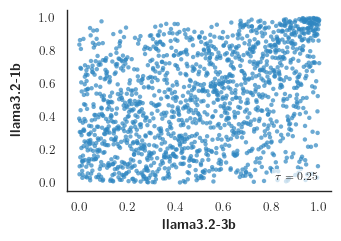

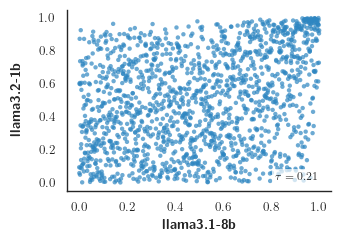

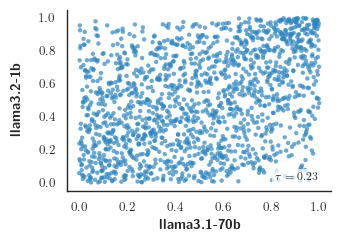

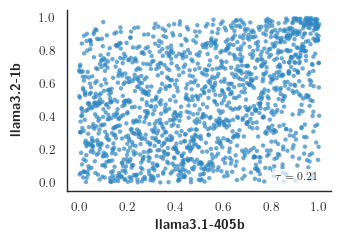

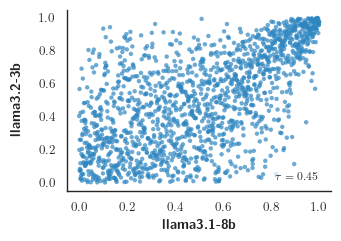

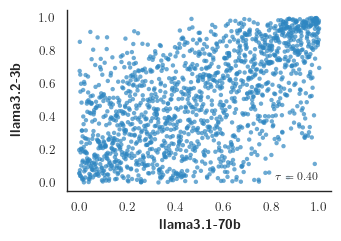

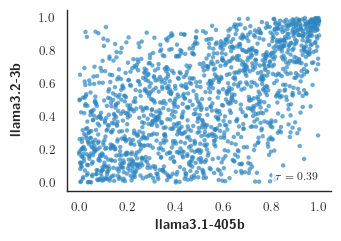

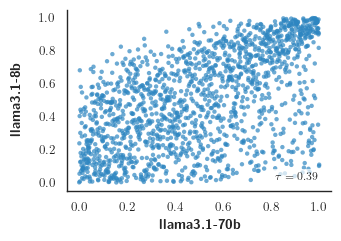

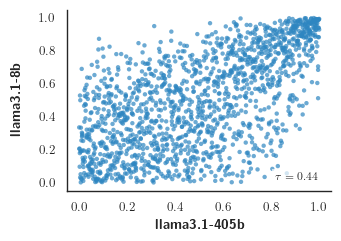

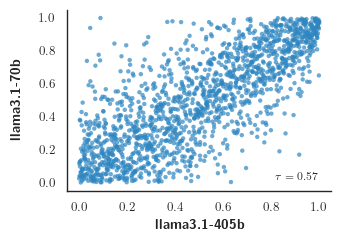

In [451]:
### Plot the correlations between the calibrated confidences of pairs of LLMs

import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import numpy as np
from matplotlib import rcParams

for j1 in range(len(CHAIN.model_names)):
    for j2 in range(j1+1, len(CHAIN.model_names)):

        c2 = np.array(calibrated_conf_test[j2])
        c1 = np.array(calibrated_conf_test[j1])

        x_smooth = (c2 > np.min(c2)) & (c2 < np.max(c2))
        y_smooth = (c1 > np.min(c1)) & (c1 < np.max(c1))

        x = c2[x_smooth & y_smooth] # columns are j2
        y = c1[x_smooth & y_smooth] # rows are j1
        name_j2 = CHAIN.model_names[j2]
        name_j1 = CHAIN.model_names[j1]

        rank_corr = kendalltau(x,y).statistic

        # Transform to copula coordinates
        x = ECDF(x)(x)
        y = ECDF(y)(y)

        # Enable LaTeX text rendering in Matplotlib for consistent fonts
        rcParams["text.usetex"] = True
        rcParams["font.family"] = "serif"
        rcParams["font.serif"] = ["Computer Modern Roman"]
        rcParams["font.size"] = 10

        sns.set_style("white")
        sns.set_context("paper", font_scale=1.0)

        fig, ax = plt.subplots(figsize=(3.5, 2.5))

        # Create a scatter plot
        ax.scatter(x, y, color="#2E86C1", edgecolor="none", alpha=0.7, linewidth=0.5, s=10)

        # Add labels and a title
        ax.set_xlabel(r"\textbf{" + name_j2 + r"}", fontsize=10)
        ax.set_ylabel(r"\textbf{" + name_j1 + r"}", fontsize=10, rotation=90, labelpad=12)
        # Remove top and right spines for a clean look
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Optionally, set a consistent x- and y-limit if needed
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)

        ax.text(
            0.95, 0.05,  # Position in axes coordinates (lower right)
            r"$\tau=" + f"{rank_corr:.2f}" + "$",  # LaTeX formatting
            transform=ax.transAxes,  # Use axes coordinates
            ha='right',  # Right alignment
            va='bottom',  # Bottom alignment
            fontsize=8,   # Smaller font size
            bbox=dict(
                facecolor='white',
                alpha=0.7,
                edgecolor='none',
                pad=2
            )
        )

In [10]:
### Compute copula p values and analyze them

import pandas as pd

N_TEST = len(calibrated_conf_test[0])

pvals = []

for j1 in range(len(CHAIN.model_names)):
    for j2 in range(j1 + 1, len(CHAIN.model_names)):
        C_j1_j2 = prepare_calibrated_conf(calibrated_conf_test, j1, j2, n_test=N_TEST)
        cvm_pval, cvm_value = compute_pval_e2e(C_j1_j2, return_test_statistic=True)
        pvals.append({"model_pair": [j1, j2], "chain": CHAIN_NAME, "benchmark": NAME, "cvm": cvm_value, "cvm_pval": cvm_pval})

def transform_data(df):
    return pd.Series({
        # 'sqrt_cvm': df['sqrt_cvm'].mean(),
        'cvm': df['cvm'].mean(),
        'n_reject': df['reject'].sum(),
        'rejection_rate': df['reject'].mean(),
        'geommean_pval': np.exp(np.mean(np.log(df['cvm_pval'].clip(lower=1e-4)))),
        'avg_pval': np.mean(df['cvm_pval'])
    })
    
df = pd.DataFrame(pvals)
print(df.groupby(by=['chain', 'benchmark'])[['cvm', 'reject', 'cvm_pval']].apply(transform_data))

                                cvm  n_reject  rejection_rate  geommean_pval  \
chain          benchmark                                                       
llama_chain    gsm8k       0.001955       0.0        0.000000       0.688446   
               medmcqa     0.004345       1.0        0.100000       0.394445   
               mmlu        0.002053       0.0        0.000000       0.568881   
               triviaqa    0.002207       0.0        0.000000       0.638408   
               truthfulqa  0.000920       0.0        0.000000       0.960780   
               xsum        0.003976       0.0        0.000000       0.404747   
qwen_oai_chain gsm8k       0.015651       2.0        0.333333       0.031969   
               medmcqa     0.004043       0.0        0.000000       0.396498   
               mmlu        0.010501       4.0        0.666667       0.057636   
               triviaqa    0.011992       2.0        0.333333       0.077565   
               truthfulqa  0.002030     

In [ ]:
from scipy.stats import kendalltau
import numpy as np

### Compute pairwise Kendall's tau

pairwise_kendalls_tau = [ 
    kendalltau(calibrated_conf_test[j1], calibrated_conf_test[j2]).statistic
        for j1 in range(len(CHAIN.model_names))
            for j2 in range(j1+1, len(CHAIN.model_names))
]